In [120]:
import pickle
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2
import time
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.layers as l
import tensorflow.keras.backend as K

import tensorflow.keras.optimizers as o
import tensorflow.keras.models as m
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

ModuleNotFoundError: No module named 'kerastuner'

In [52]:
mnist = keras.datasets.mnist 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# x_train = x_train.reshape([-1, 28, 28, 1])
# x_test = x_test.reshape([-1, 28, 28, 1])


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("test shape: ", x_train.shape)
print("labe shape: ", y_train.shape)

test shape:  (60000, 28, 28)
labe shape:  (60000, 10)


---

## Create some augmentated dataset

In [109]:
print("before: ", x_train.shape ," and ", labels.shape)

dataset, labels = augment_data(x_train, y_train, augementation_factor=1)

print("after: ", dataset.shape ," and ", labels.shape)

before:  (60000, 28, 28)  and  (300000, 10)
after:  (300000, 28, 28)  and  (300000, 10)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


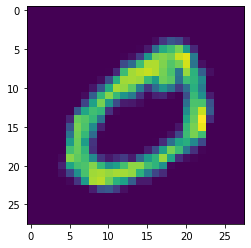

In [95]:
print(labels[7])
plt.imshow(dataset[7].reshape(28,28))
plt.show()

## Prepare the data

In [118]:
dataset = dataset.reshape([-1, 28, 28, 1])
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

## Make the Network

In [99]:
model = m.Sequential()

model.add(l.Conv2D(49, (3,3), padding='same', activation='relu', input_shape = (28,28,1)))
model.add(l.MaxPooling2D((3,3)))
model.add(l.Conv2D(36, (3,3), padding='same', activation='relu'))
model.add(l.MaxPooling2D((3,3)))

model.add(l.Flatten())
model.add(l.Dense(32, activation="relu"))
model.add(l.Dropout(rate=0.5))
model.add(l.Dense(64, activation="relu"))

model.add(l.Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 49)        490       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 49)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 36)          15912     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 324)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

### CallBacks: TensorBoard + EarlyStop

In [114]:
name = "tf_{}.log".format(int(time.time()))
print("lon_name: ",name)
tensorboard = TensorBoard(log_dir='logs/{}'.format(name))

earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1, patience=0,
    verbose=0, mode='auto',
    baseline=None,
    restore_best_weights=False
)

lon_name:  tf_1579186005.log


In [119]:
model.fit(x_train, y_train, epochs=3, callbacks=[tensorboard, earlystop], validation_data = (x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 21s 351us/sample - loss: 0.0713 - accuracy: 0.9780 - val_loss: 0.1283 - val_accuracy: 0.9618
Epoch 2/3
60000/60000 [==============================] - 21s 344us/sample - loss: 0.0712 - accuracy: 0.9782 - val_loss: 0.1581 - val_accuracy: 0.9509


---

## Keras - tuner

In [112]:
print(name)

tf_1579184746.log


---

## Augmente the Dataset

In [90]:
'''
    This function peforms various data augmentation techniques to the dataset
    
    @parameters:
        dataset: the feature training dataset in numpy array with shape [num_examples, num_rows, num_cols, num_channels] (since it is an image in numpy array)
        dataset_labels: the corresponding training labels of the feature training dataset in the same order, and numpy array with shape [num_examples, <anything>]
        augmentation_factor: how many times to perform augmentation.
        use_random_rotation: whether to use random rotation. default: true
        use_random_shift: whether to use random shift. default: true
        use_random_shear: whether to use random shear. default: false
        use_random_zoom: whether to use random zoom. default: false
        
use_random_shear=True, use_random_shift=False, use_random_zoom=False
'''

def augment_data(dataset, dataset_labels, augementation_factor=1, ROT_DEGGREES=20):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):

        for i in range(0, augementation_factor):
            # original image:
            augmented_image.append(dataset[num])
            augmented_image_labels.append(dataset_labels[num])
            
            for degrees in range((-1)*ROT_DEGGREES, ROT_DEGGREES, 10):
            #rotate 
                height, width = dataset[num].shape
                rotation_matrix = cv2.getRotationMatrix2D((width/2,height/2), degrees ,1)
                rotated_image = cv2.warpAffine(dataset[num], rotation_matrix, (width, height))

                augmented_image.append(rotated_image)
                augmented_image_labels.append(dataset_labels[num])
           

    return np.array(augmented_image), np.array(augmented_image_labels)